In [1]:
import sys
sys.path.append('../src')

import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os

from factors import PriceMomentum
from backtest.engine import BacktestEngine
from backtest.portfolio import Portfolio

load_dotenv()

conn = psycopg2.connect(
    host=os.getenv("DB_HOST"),
    user=os.getenv("DB_USER"),
    password=os.getenv("DB_PASSWORD"),
    database=os.getenv("DB_NAME"),
    port=os.getenv("DB_PORT")
)

In [2]:
query = """
SELECT ticker, date, adj_close
FROM daily_prices
ORDER BY ticker, date
"""
prices_long = pd.read_sql(query, conn, parse_dates=['date'])
prices = prices_long.pivot(index='date', columns='ticker', values='adj_close')
print(f"Loaded prices: {prices.shape}")

/var/folders/4d/xhxv9bj17jlcmhb9y9x4_rnh0000gn/T/ipykernel_23009/1223238300.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  prices_long = pd.read_sql(query, conn, parse_dates=['date'])


Loaded prices: (1261, 100)


In [3]:
momentum_252 = PriceMomentum(lookback_days=252, skip_days=20)
factor_values = momentum_252.calculate(prices)
print(f"Calculated momentum: {factor_values.shape}")

Calculated momentum: (1261, 100)


In [8]:
# Run backtest
engine = BacktestEngine(
    initial_capital=1_000_000,
    commission_pct=0.001,
    rebalance_frequency='monthly'
)

portfolio = engine.run_long_short(
    prices=prices,
    factor_values=factor_values,
    long_pct=0.2,
    short_pct=0.2,
    start_date='2022-03-01'
)

Running backtest for 2022-03-01 to 2026-02-13
Rebalancing 48 times monthly
[0/994] Rebalance on 2022-03-01: $1,000,000
[23/994] Rebalance on 2022-04-01: $999,500
[43/994] Rebalance on 2022-05-02: $960,091
[64/994] Rebalance on 2022-06-01: $971,034
[85/994] Rebalance on 2022-07-01: $920,041
[105/994] Rebalance on 2022-08-01: $961,341
[128/994] Rebalance on 2022-09-01: $964,401
[149/994] Rebalance on 2022-10-03: $941,105
[170/994] Rebalance on 2022-11-01: $992,407
[191/994] Rebalance on 2022-12-01: $1,013,118
[212/994] Rebalance on 2023-01-03: $991,330
[232/994] Rebalance on 2023-02-01: $991,760
[251/994] Rebalance on 2023-03-01: $981,917
[274/994] Rebalance on 2023-04-03: $978,046
[293/994] Rebalance on 2023-05-01: $979,643
[315/994] Rebalance on 2023-06-01: $973,090
[336/994] Rebalance on 2023-07-03: $1,002,659
[356/994] Rebalance on 2023-08-01: $1,016,060
[379/994] Rebalance on 2023-09-01: $1,014,611
[399/994] Rebalance on 2023-10-02: $985,541
[421/994] Rebalance on 2023-11-01: $969,6

In [12]:
# Performance metrics

stats = portfolio.get_summary_stats()

print(f"Init capital: {portfolio.initial_capital:,.0f}")
print(f"Final value: ${stats['final_value']:,.0f}")
print(f"Total returns: {stats['total_returns']:.2%}")
print(f"CAGR: {stats['cagr']:.2%}")
print(f"Annual volatility: {stats['annual_volality']:.2%}")
print(f"Sharpe ratio: {stats['sharpe_ratio']:.2f}")
print(f"Max drawdown: {stats['max_drawdown']:.2%}")

Init capital: 1,000,000
Final value: $1,258,164
Total returns: 25.82%
CAGR: 6.00%
Annual volatility: 9.25%
Sharpe ratio: 0.68
Max drawdown: -10.68%


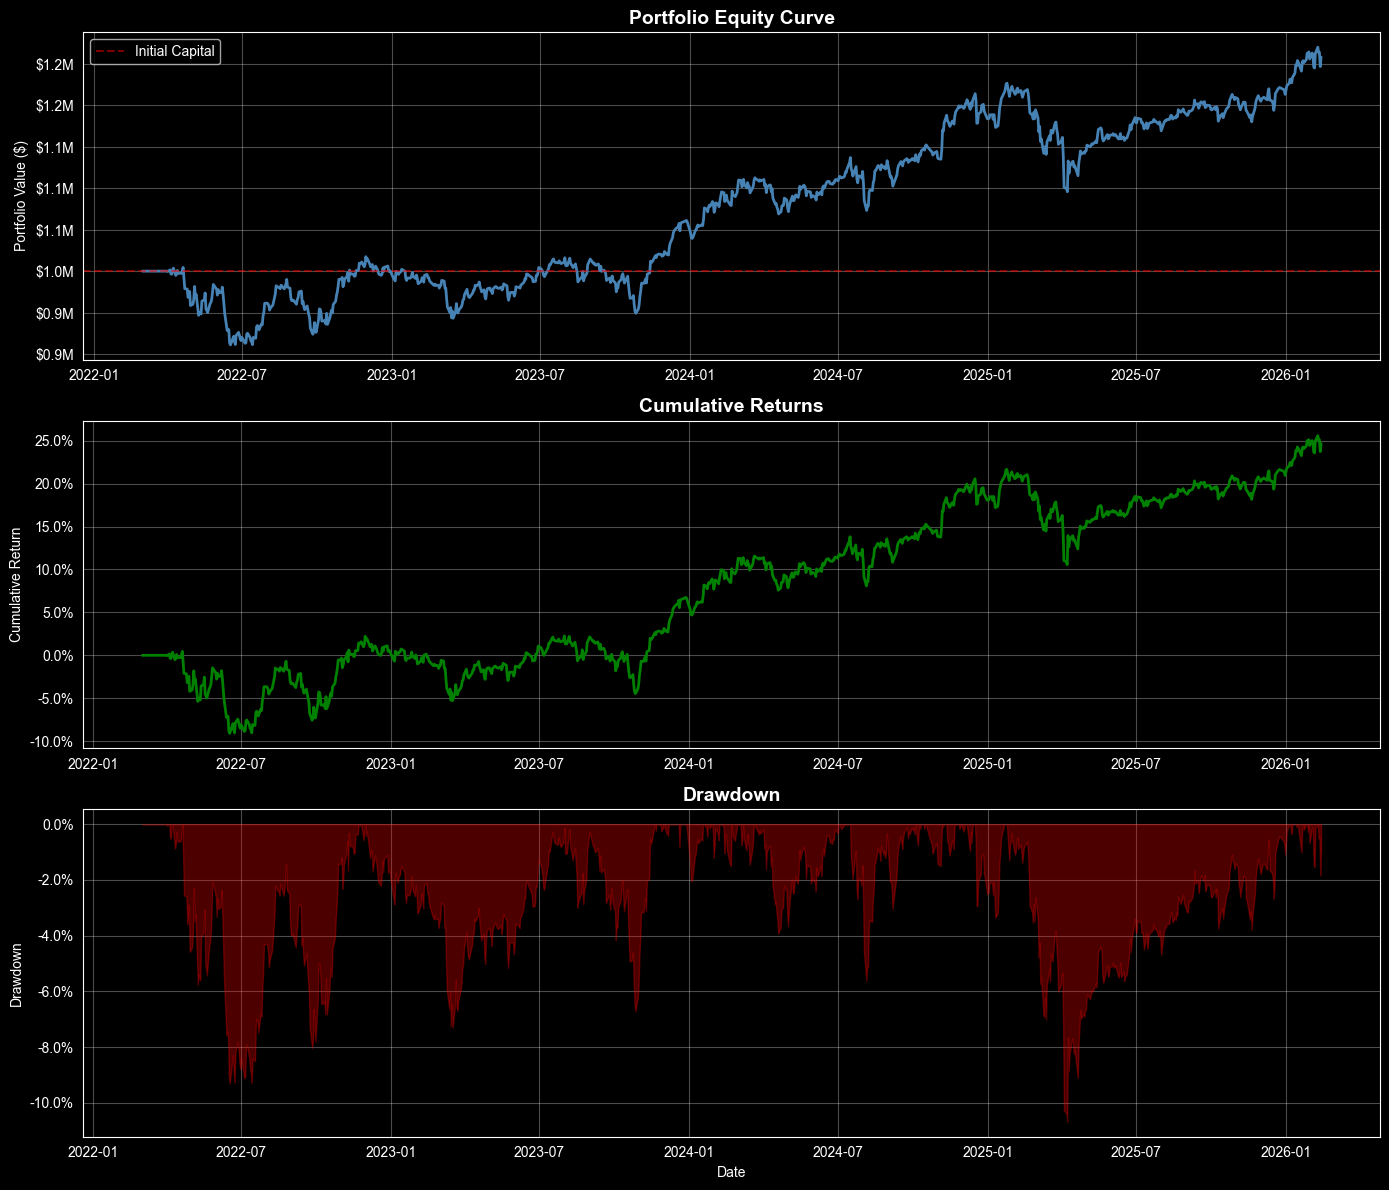

In [13]:
# Plot equity curve
perf_df = portfolio.get_performance_df()

fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Equity curve
axes[0].plot(perf_df.index, perf_df['total_value'], linewidth=2, color='steelblue')
axes[0].axhline(y=portfolio.initial_capital, color='red', linestyle='--', alpha=0.5, label='Initial Capital')
axes[0].set_title('Portfolio Equity Curve', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Portfolio Value ($)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))

# Returns
returns = portfolio.calculate_returns()
axes[1].plot(returns.index, returns.cumsum(), linewidth=2, color='green')
axes[1].set_title('Cumulative Returns', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Cumulative Return')
axes[1].grid(True, alpha=0.3)
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1%}'))

# Drawdown
cumulative = (1 + returns).cumprod()
running_max = cumulative.cummax()
drawdown = (cumulative - running_max) / running_max
axes[2].fill_between(drawdown.index, 0, drawdown, color='red', alpha=0.3)
axes[2].set_title('Drawdown', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Drawdown')
axes[2].grid(True, alpha=0.3)
axes[2].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1%}'))

plt.tight_layout()
plt.show()

/var/folders/4d/xhxv9bj17jlcmhb9y9x4_rnh0000gn/T/ipykernel_23009/354428433.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sp500 = pd.read_sql(query_index, conn, index_col='date', parse_dates=['date'])


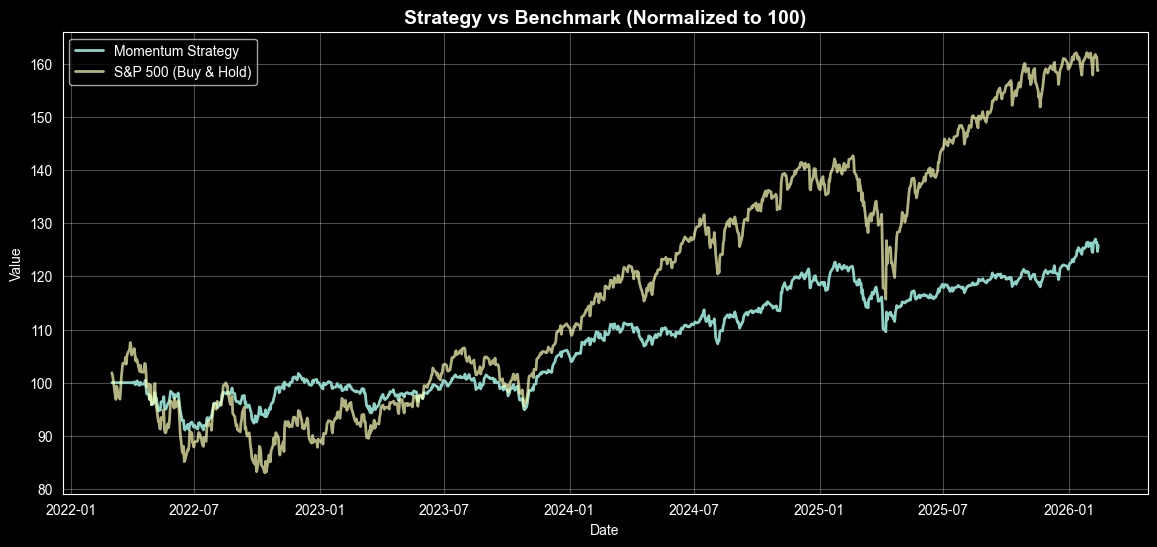


Strategy Total Return: 25.82%
S&P 500 Total Return:  58.75%


In [14]:
# Compare with buy-and-hold benchmark
# Use S&P 500 index if available
query_index = """
SELECT date, close
FROM market_data
WHERE index_name = '^GSPC'
ORDER BY date
"""
sp500 = pd.read_sql(query_index, conn, index_col='date', parse_dates=['date'])

# Align dates
common_dates = perf_df.index.intersection(sp500.index)
strategy_returns = perf_df.loc[common_dates, 'total_value'].pct_change()
sp500_returns = sp500.loc[common_dates, 'close'].pct_change()

# Normalize to 100
strategy_norm = (1 + strategy_returns).cumprod() * 100
sp500_norm = (1 + sp500_returns).cumprod() * 100

plt.figure(figsize=(14, 6))
plt.plot(strategy_norm.index, strategy_norm, label='Momentum Strategy', linewidth=2)
plt.plot(sp500_norm.index, sp500_norm, label='S&P 500 (Buy & Hold)', linewidth=2, alpha=0.7)
plt.title('Strategy vs Benchmark (Normalized to 100)', fontsize=14, fontweight='bold')
plt.ylabel('Value')
plt.xlabel('Date')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nStrategy Total Return: {(strategy_norm.iloc[-1] - 100):.2f}%")
print(f"S&P 500 Total Return:  {(sp500_norm.iloc[-1] - 100):.2f}%")

In [16]:
# Analyze what would have happened with long-only

# Re-run with long-only (no shorts)
engine_long_only = BacktestEngine(
    initial_capital=1_000_000,
    commission_pct=0.001,
    rebalance_frequency='monthly'
)

portfolio_long_only = engine_long_only.run_long_short(
    prices=prices,
    factor_values=factor_values,
    long_pct=0.2,
    short_pct=0.0,  # NO SHORTS
    start_date='2022-03-01'
)

stats_long_only = portfolio_long_only.get_summary_stats()
print(f"\nLong-Only Strategy Return: {stats_long_only['total_returns']:.2%}")

Running backtest for 2022-03-01 to 2026-02-13
Rebalancing 48 times monthly
[0/994] Rebalance on 2022-03-01: $1,000,000
[23/994] Rebalance on 2022-04-01: $999,500
[43/994] Rebalance on 2022-05-02: $960,091
[64/994] Rebalance on 2022-06-01: $971,034
[85/994] Rebalance on 2022-07-01: $920,041
[105/994] Rebalance on 2022-08-01: $961,341
[128/994] Rebalance on 2022-09-01: $964,401
[149/994] Rebalance on 2022-10-03: $941,105
[170/994] Rebalance on 2022-11-01: $992,407
[191/994] Rebalance on 2022-12-01: $1,013,118
[212/994] Rebalance on 2023-01-03: $991,330
[232/994] Rebalance on 2023-02-01: $991,760
[251/994] Rebalance on 2023-03-01: $981,917
[274/994] Rebalance on 2023-04-03: $978,046
[293/994] Rebalance on 2023-05-01: $979,643
[315/994] Rebalance on 2023-06-01: $973,090
[336/994] Rebalance on 2023-07-03: $1,002,659
[356/994] Rebalance on 2023-08-01: $1,016,060
[379/994] Rebalance on 2023-09-01: $1,014,611
[399/994] Rebalance on 2023-10-02: $985,541
[421/994] Rebalance on 2023-11-01: $969,6